# Databricks wheel demo

This notebook demonstrates a first pass at how we could share pyspark code in databricks.

### Audience

This notebook and the corresponding presentation are applicable to anyone who work within databricks at prodigy.

## Background

Now that we have completed the core data platform migration, our next focus should be on defining robust processes for building within the platform. While there are multiple areas that could use some work, the area this notebook covers is improving code sharing within databricks notebooks.

As we build ETLs and (soon enough) machine learning and statistical models in spark, we should look to see what code could be reused and shared with others. The ability to write code in one place and have it used in multiple places allows us to move faster when developing new features and reduces manual errors from copying and pasting code snippets.

Right now in databricks the main way we currently do code sharing in notebooks has been through the [databricks notebook workflow commands](https://docs.databricks.com/notebooks/notebook-workflows.html#notebook-workflows). This worked to start, but comes with a few downsides. For one, you are unable to import a portion of the imported notebook. So if a notebook contains 10 functions and you only need to get one, you still have to import the other 9 which is wasted compute. Secondly, to make an update to the shared notebook requires updating all the notebooks which consume it. This is a lot of work and requires a versioning tool which we would need to create in-house for databricks notebooks. Instead of recreating the wheel, we can solve these problems by using existing tools for building and sharing python code.

## Installation and setup

Before we get to the more interesting stuff, this section goes over anything you will need to install for running the commands in this notebook.

First you should have the [prodigy-databricks](https://github.com/SMARTeacher/prodigy-databricks) repository cloned to your machine. Simply change the cell below to include the full path to where you'd like to store the repository before running the clone command below. If you already have the repository setup locally, you can skip the clone step.

In [9]:
%env DATABRICKS_REPO_PATH=/home/lennox/prodigy/prodigy-databricks

env: DATABRICKS_REPO_PATH=/home/lennox/prodigy/prodigy-databricks


In [10]:
! git clone https://github.com/SMARTeacher/prodigy-databricks $DATABRICKS_REPO_PATH

fatal: destination path '/home/lennox/prodigy/prodigy-databricks' already exists and is not an empty directory.


This notebook also assumes you have the databricks CLI setup and have the permissions to create / edit / delete a cluster. Assuming you have python and pip installed locally, you can install the databricks CLI locally via the following command.

In [11]:
! pip install databricks-cli

## File structure of python library

With our dependencies setup, let's get to the interesting stuff. Looking at the root folder of the prodigy-databricks repository, you should see the [libraries](https://github.com/SMARTeacher/prodigy-databricks/tree/master/libraries) folder and the [prodigy-databricks-utilities](https://github.com/SMARTeacher/prodigy-databricks/tree/master/libraries/prodigy-databricks-utilities) directory inside of that. The latter directory is the one that contains the source code for the python package we will consuming later. If you want to learn more about the structure of python packages feel free to read this [documentation here](https://docs.python-guide.org/writing/structure/), but it is not necessary to start. An important file to note is the `setup.py` file which includes the version of the python package used when creeating the shareable package.

In [12]:
! cat $DATABRICKS_REPO_PATH/libraries/prodigy-databricks-utilities/setup.py

from os import path

import setuptools

this_directory = path.abspath(path.dirname(__file__))
with open(path.join(this_directory, "README.md"), encoding="utf-8") as f:
    long_description = f.read()

setuptools.setup(
    name="prodigy-databricks-utilities",
    version="0.1.0",
    author="Lennox Stevenson",
    author_email="lennox.stevenson@prodigygame.com",
    license="LICENSE.txt",
    description="Helper functions for working with pyspark at prodigy.",
    url="https://github.com/SMARTeacher/prodigy-databricks/libraries/prodigy_databricks_utilities/README.md",
    long_description=long_description,
    long_description_content_type="text/markdown",
    classifiers=[
        "Development Status :: 3 - Alpha",
        "Intended Audience :: Developers",
        "Topic :: Software Development :: Libraries :: Python Modules",
        "Programming Language :: Python :: 3.8",
        "Programming Language :: Python :: 3.9",
    ],
    keywords=["databricks", "pyspark", "spark"],
    p

If you dig a bit deeper, you can see a file called `snake_case_column_names.py` which currently is the only thing being exported by this python package. This function converts the column names for a spark dataframe to follow the snake_case naming convention. While I won't cover it here, you can also see a corresponding test file in the project which includes a basic set of unit tests which you can read for understanding what the function does.

In [13]:
! cat $DATABRICKS_REPO_PATH/libraries/prodigy-databricks-utilities/prodigy_databricks_utilities/etl/snake_case_column_names.py

import re


def _camel_to_snake_case(name):
    name = re.sub("(.)([A-Z]+[a-z]+)", r"\1_\2", name)
    return re.sub("([a-z0-9])([A-Z])", r"\1_\2", name).lower()


def snake_case_column_names(df):
    renamed_df = df

    for column in renamed_df.columns:
        renamed_df = renamed_df.withColumnRenamed(column, _camel_to_snake_case(column))

    return renamed_df


## Consuming shared utility code

While the function shown above isn't anything mind blowing, we can use simple functions like this one to build more complex notebooks.

As part of the deployment process for the `prodigy-databricks` repository, whenever someone merges code into the `master` branch a script gets run which builds and uploads a `prodigy-databricks-utility` python wheel to databricks. You can see the exact process for which this deployment gets done in the [circleCI config file](https://github.com/SMARTeacher/prodigy-databricks/blob/master/.circleci/config.yml), but the main thing to know is that it uploads the python wheel to the databricks file system (DBFS) in the location `/FileStore/jars/prodigy-databricks-utilities`. We can search what versions of the package have been uploaded to databricks simply by searching using the databricks cli.

In [14]:
! databricks fs ls dbfs:/FileStore/jars/prodigy-databricks-utilities

prodigy_databricks_utilities-0.1.0-py3-none-any.whl


The python wheel is stored in this location so that any notebook or cluster within the workspace can consume it. To install the python wheel on a cluster you are using, you can do so through the GUI following the [instructions here](https://docs.databricks.com/libraries.html#install-a-library-on-a-cluster). You can also install the library on a cluster via the library API, which I will use in this notebook.

To start, fill in the value below to a cluster you want to install the library on. This value should equal the id of the cluster which can be found in the databricks UI.

In [25]:
%env CLUSTER_ID=1115-003404-feats895

env: CLUSTER_ID=1115-003404-feats895


To install a library onto a cluster, it can't be in the terminated mode (off). You can turn on the cluster through the UI or by running the command below.

In [28]:
! databricks clusters start --cluster-id $CLUSTER_ID

We can now use the library CLI to install the package that is stored in the databricks file system on a cluster.

In [29]:
! databricks libraries install --cluster-id $CLUSTER_ID --whl dbfs:/FileStore/jars/prodigy-databricks-utilities/prodigy_databricks_utilities-0.1.0-py3-none-any.whl

That's it! With the python wheel now installed on the cluster, we can now import the snake case function from before and use it in our code. The snippet belows shows an example of its use in pyspark which can be found at https://dbc-f60a397b-b770.cloud.databricks.com/?o=2195973097651747#notebook/3245379466691903/command/3245379466691904

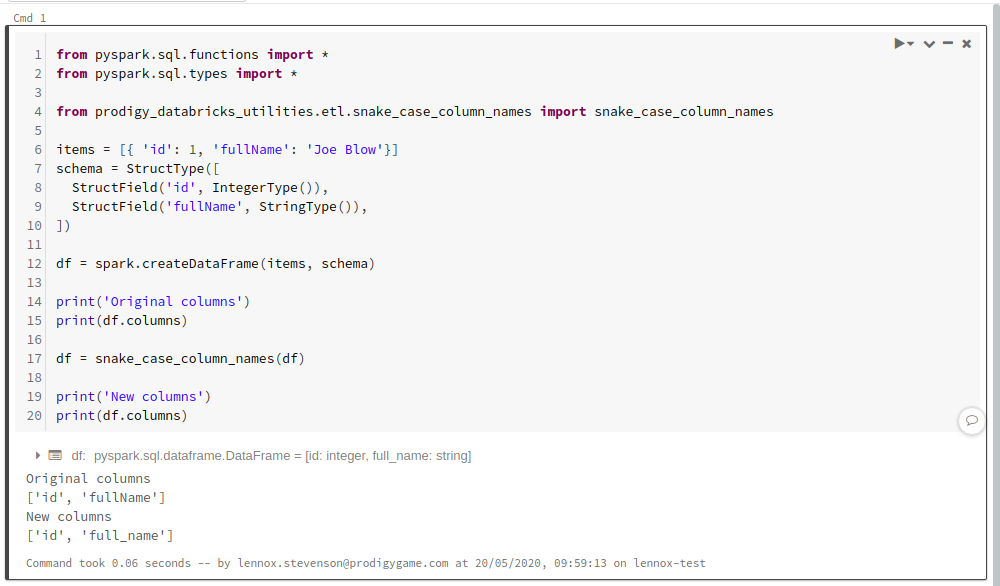

In [2]:
from IPython.display import Image
Image(filename='spark_snippet.png')